# Comparison of predictions

- See preprocessing of gene expression and prediction were done in CaDRReS2/pipeline/* and 03_*
- Convert predicted delta to cv to cell death percentage

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from collections import Counter

sns.set(font_scale=1.5)
sns.set_style('ticks')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
from IPython.display import HTML, display

In [39]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
mpl.rc("savefig", dpi=300)

##### Compare between cell line prediction and cell type-specific prediction

In [40]:
dosage_shifted = False

for experimental validation

In [41]:
dosage_used = '3 fold' # All for HN, '9 fold' '3 fold' 'Median IC50' 

for calculating % cell death

In [42]:
# log2_median_ic50, log2_median_ic50_9f, log2_median_ic50_hn, log2_median_ic50_9f_hn, log2_median_ic50_3f_hn, log2_max_conc
dosage_ref = 'log2_median_ic50_hn' # log2_median_ic50_hn | log2_median_ic50_3f_hn
model_name = 'RWEN'

Read predictions

In [43]:
current_dir = '../result/HN_model/cell_TPM/'

In [44]:
if dosage_shifted:
    pred_single_df = pd.read_csv(current_dir + 'pred_drug_kill_{}_{}_shifted.csv'.format(dosage_ref, model_name))
    pred_combi_df = pd.read_csv(current_dir + 'pred_combi_kill_{}_{}_shifted.csv'.format(dosage_ref, model_name))
else:
    pred_single_df = pd.read_csv(current_dir + 'pred_drug_kill_{}_{}.csv'.format(dosage_ref, model_name))
    pred_combi_df = pd.read_csv(current_dir + 'pred_combi_kill_{}_{}.csv'.format(dosage_ref, model_name))

Read experimental data

In [45]:
##### Combined replicate #####

validation_fname_list = ['../result/validation/validation_triplicate_2019_09_13.xlsx', '../result/validation/validation_replicates_2019_06_24.xlsx']

cv_single_df_list = []
cv_combi_df_list = []

for validation_fname in validation_fname_list:

    cv_single_df = pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2])
    cv_single_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
    cv_single_df = cv_single_df.reset_index().groupby(['File name', 'Dosage', 'Drug', 'Replicate']).median().reset_index() # just to rearrange columns

    cv_combi_df = pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])
    cv_combi_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
    cv_combi_df = cv_combi_df.reset_index().groupby(['File name', 'Dosage', 'Drug', 'Replicate']).median().reset_index()
    
    cv_single_df_list += [cv_single_df]
    cv_combi_df_list += [cv_combi_df]

cv_df = pd.concat(cv_single_df_list + cv_combi_df_list, axis=0)
cv_df = cv_df[~cv_df['Drug'].isin(['DMSO', 'Staurosporin'])]
cv_df.head()

,File name,Dosage,Drug,Replicate,HN120,HN137,HN148,HN159,HN160,HN182
0,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,1,56.98,64.74,40.52,26.77,97.41,67.09
1,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,2,58.10,64.20,38.30,25.42,96.90,68.63
2,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,3,53.09,59.52,35.23,24.12,93.86,66.52
6,validation_triplicate_2019_09_13.xlsx,3 fold,Docetaxel,1,81.52,71.17,84.23,86.19,88.00,67.97
7,validation_triplicate_2019_09_13.xlsx,3 fold,Docetaxel,2,80.69,67.84,78.09,81.28,86.22,70.59


In [46]:
##### Not combined replicate #####

# validation_fname_list = ['../result/validation/validation_triplicate_2019_09_13.xlsx', '../result/validation/validation_replicates_2019_06_24.xlsx']

# cv_single_df_list = []
# cv_combi_df_list = []

# for validation_fname in validation_fname_list:

#     cv_single_df = pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2])
#     cv_single_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
#     cv_single_df = cv_single_df.reset_index()

#     cv_combi_df = pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])
#     cv_combi_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
#     cv_combi_df = cv_combi_df.reset_index()
    
#     cv_single_df_list += [cv_single_df]
#     cv_combi_df_list += [cv_combi_df]

# cv_df = pd.concat(cv_single_df_list + cv_combi_df_list, axis=0)
# cv_df = cv_df[~cv_df['Drug'].isin(['DMSO', 'Staurosporin'])]
# cv_df.head()

In [47]:
# patient_list = ['HN120', 'HN137', 'HN148', 'HN159', 'HN160', 'HN182']
patient_list = ['HN120', 'HN137', 'HN148', 'HN159', 'HN160']
# patient_list = ['HN120', 'HN137', 'HN148', 'HN160']
# patient_list = ['HN120', 'HN137', 'HN148', 'HN159']
# patient_list = ['HN120', 'HN137', 'HN148', 'HN160']

# single_drug_id_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302] + [1012]
# single_drug_list = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103'] + ['Vorinostat']
# combi_drug_list = ['Docetaxel|Afatinib', 'Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Epothilone B|Afatinib', 'Gefitinib|Afatinib', 'Gefitinib|Epothilone B'] + ['Afatinib|Obatoclax Mesylate', 'Epothilone B|PI-103'] + ['Doxorubicin|Vorinostat']

single_drug_id_list = [1007, 133, 201, 1010] + [182, 301, 302] + [1012]
single_drug_list = ['Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103'] + ['Vorinostat']
combi_drug_list = ['Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Gefitinib|Epothilone B'] + ['Epothilone B|PI-103'] + ['Doxorubicin|Vorinostat']

# single_drug_id_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302]
# single_drug_list = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103']
# combi_drug_list = ['Docetaxel|Afatinib', 'Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Epothilone B|Afatinib', 'Gefitinib|Afatinib', 'Gefitinib|Epothilone B'] + ['Afatinib|Obatoclax Mesylate', 'Epothilone B|PI-103']

# single_drug_id_list = [1007, 133, 1010, 182, 301, 302]
# single_drug_list = ['Docetaxel', 'Doxorubicin', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103']
# combi_drug_list = ['Docetaxel|Gefitinib']

In [48]:
# read reference dosages file
dosage_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
dosage_df = dosage_df.loc[single_drug_id_list]

In [49]:
##### Check consistency across triplicate #####

# validation_fname = validation_fname_list[0]

# cv_new_df = pd.concat([pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2]), pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])], axis=0).reset_index()
# cv_new_df = cv_new_df[~cv_new_df['Drug'].isin(['DMSO', 'Staurosporin'])]
# cv_new_df = cv_new_df.set_index(['Drug', 'Dosage', 'Replicate']).stack().reset_index()
# cv_new_df.columns = ['Drug', 'Dosage', 'Replicate', 'Patient', 'Viability']
# cv_new_df = cv_new_df.groupby(['Dosage', 'Drug', 'Patient', 'Replicate']).sum().unstack()

# sns.pairplot(cv_new_df, plot_kws={'s':10, 'alpha':0.75, 'linewidth':0}, diag_kws={'bins':20}, aspect=1.15)

##### Preprocess predicted and observed

In [50]:
obs_kill_df = 100 - cv_df.set_index(['Dosage', 'Drug', 'File name', 'Replicate']).astype(float)
obs_kill_df = obs_kill_df.loc[dosage_used]

In [51]:
obs_kill_df.head(10)

HN120  HN137  \
Drug         File name                             Replicate                 
Afatinib     validation_triplicate_2019_09_13.xlsx 1          47.25  34.18   
                                                   2          44.07  28.62   
                                                   3          48.24  31.68   
Docetaxel    validation_triplicate_2019_09_13.xlsx 1          49.10  61.99   
                                                   2          45.15  58.86   
                                                   3          50.05  58.84   
Doxorubicin  validation_triplicate_2019_09_13.xlsx 1          67.53  63.16   
                                                   2          64.43  62.38   
                                                   3          67.12  61.73   
Epothilone B validation_triplicate_2019_09_13.xlsx 1          55.98  71.19   

                                                              HN148  HN159  \
Drug         File name                             Replicate                 
Afatinib     validation_triplicate_2019_09_13.xlsx 1          55.59  73.87   
                                                   2          58.39  73.48   
                                                   3          57.19  74.51   
Docetaxel    validation_triplicate_2019_09_13.xlsx 1          31.87  35.45   
                                                   2          36.26  29.41   
                                                   3          32.00  32.61   
Doxorubicin  validation_triplicate_2019_09_13.xlsx 1          50.80  32.72   
                                                   2          54.29  29.53   
                                                   3          53.64  34.09   
Epothilone B validation_triplicate_2019_09_13.xlsx 1          36.99  43.62   

                                                              HN160  HN182  
Drug         File name                             Replicate                
Afatinib     validation_triplicate_2019_09_13.xlsx 1           3.39  27.10  
                                                   2           5.57  30.12  
                                                   3           4.97  30.80  
Docetaxel    validation_triplicate_2019_09_13.xlsx 1          26.92  56.40  
                                                   2          26.08  54.51  
                                                   3          25.09  58.38  
Doxorubicin  validation_triplicate_2019_09_13.xlsx 1          24.21  51.81  
                                                   2          23.48  52.38  
                                                   3          23.81  54.06  
Epothilone B validation_triplicate_2019_09_13.xlsx 1          20.77  78.44

In [52]:
pred_single_df = pred_single_df[pred_single_df['drug_id'].isin(single_drug_id_list)]

pred_combi_df = pred_combi_df[pred_combi_df['drug_id_A'].isin(single_drug_id_list) & pred_combi_df['drug_id_B'].isin(single_drug_id_list)]

pred_combi_df.loc[:, 'Combi Name 1'] = pred_combi_df['drug_name_A'].values + '|' + pred_combi_df['drug_name_B'].values
pred_combi_df.loc[:, 'Combi Name 2'] = pred_combi_df['drug_name_B'].values + '|' + pred_combi_df['drug_name_A'].values

temp1 = pred_combi_df['Combi Name 1'][pred_combi_df['Combi Name 1'].isin(combi_drug_list)]
temp2 = pred_combi_df['Combi Name 2'][pred_combi_df['Combi Name 2'].isin(combi_drug_list)]
combi_name = pd.concat([temp1, temp2]).values

pred_combi_df = pd.concat([pred_combi_df[pred_combi_df['Combi Name 1'].isin(combi_drug_list)], pred_combi_df[pred_combi_df['Combi Name 2'].isin(combi_drug_list)]])
pred_combi_df.loc[:, 'Combi Name'] = combi_name
pred_combi_df = pred_combi_df[pred_combi_df['Combi Name'].isin(combi_drug_list)]

In [53]:
pred_single_df.head()

,patient,drug_id,delta,kill,drug_name
0,HN120,1007,-0.46,56.82,Docetaxel
1,HN120,133,-3.11,87.30,Doxorubicin
2,HN120,201,-2.13,76.85,Epothilone B
3,HN120,1010,1.48,33.41,Gefitinib
4,HN120,182,-1.97,75.64,Obatoclax Mesylate


In [54]:
pred_combi_df.head()

,patient,drug_id_A,drug_name_A,drug_id_B,drug_name_B,cluster_p,cluster_kill_A,cluster_kill_B,kill_A,kill_B,kill_C,improve,improve_p,sum_kill_dif,Combi Name 1,Combi Name 2,Combi Name
1,HN120,1007,Docetaxel,201,Epothilone B,1,56.82,76.85,56.82,76.85,90.01,13.15,0.17,20.04,Docetaxel|Epothilone B,Epothilone B|Docetaxel,Docetaxel|Epothilone B
2,HN120,1007,Docetaxel,1010,Gefitinib,1,56.82,33.41,56.82,33.41,71.25,14.43,0.25,23.41,Docetaxel|Gefitinib,Gefitinib|Docetaxel,Docetaxel|Gefitinib
12,HN120,133,Doxorubicin,1012,Vorinostat,1,87.30,69.75,87.30,69.75,96.16,8.86,0.10,17.54,Doxorubicin|Vorinostat,Vorinostat|Doxorubicin,Doxorubicin|Vorinostat
16,HN120,201,Epothilone B,302,PI-103,1,76.85,96.18,76.85,96.18,99.12,2.93,0.03,19.33,Epothilone B|PI-103,PI-103|Epothilone B,Epothilone B|PI-103
29,HN137,1007,Docetaxel,201,Epothilone B,1,53.62,80.92,53.62,80.92,91.15,10.23,0.13,27.30,Docetaxel|Epothilone B,Epothilone B|Docetaxel,Docetaxel|Epothilone B


### Compare for all lines and drugs

In [55]:
pred_single_kill_df = pred_single_df[['patient', 'drug_name', 'kill']].pivot(index='drug_name', columns='patient', values='kill')
#pred_single_delta_df = pred_single_df[['patient', 'drug_name', 'delta']].pivot(index='drug_name', columns='patient', values='delta')
pred_combi_kill_df = pred_combi_df[['patient', 'Combi Name', 'kill_C']].pivot(index='Combi Name', columns='patient', values='kill_C')

obs_single_kill_df = obs_kill_df.loc[single_drug_list, patient_list]
obs_combi_kill_df = obs_kill_df.loc[combi_drug_list, patient_list]

In [56]:
sns.set(font_scale=1.25)
sns.set_style('ticks')

cmap = plt.cm.get_cmap('tab10', 10)
colors = cmap(np.linspace(0, 1, 10))
patient_color_dict = dict(zip(patient_list, colors[0:len(patient_list)]))
drug_color_dict = dict(zip(single_drug_list, colors[0:len(single_drug_list)]))
combi_color_dict = dict(zip(combi_drug_list, colors[0:len(combi_drug_list)]))

drug_marker_dict = dict(zip(single_drug_list, ['o', 'v', '^', '<', '>', 'd', 's']))
combi_marker_dict = dict(zip(combi_drug_list, ['p', '*', 'P', 'X', 'h']))

##### For single drug

In [57]:
obs_df = obs_single_kill_df.loc[single_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug', 'File name', 'Replicate', 'Patient', 'Observed % cell death']

pred_df = pred_single_kill_df.loc[single_drug_list, patient_list].stack().reset_index()
pred_df = pred_single_kill_df.loc[[d[0] for d in obs_single_kill_df.index], patient_list].stack().reset_index()
pred_df.columns = ['Drug', 'Patient', 'Predicted % cell death']

scatter_single_df = pd.concat([obs_df, pred_df[['Predicted % cell death']]], axis=1)
scatter_single_df.loc[:, 'Replicate'] = scatter_single_df['Replicate'].astype(str)
print (scatter_single_df.shape)
scatter_single_df.tail()

(125, 6)


,Drug,File name,Replicate,Patient,Observed % cell death,Predicted % cell death
120,PI-103,validation_replicates_2019_06_24.xlsx,2,HN120,76.42,96.18
121,PI-103,validation_replicates_2019_06_24.xlsx,2,HN137,79.03,95.62
122,PI-103,validation_replicates_2019_06_24.xlsx,2,HN148,84.00,96.08
123,PI-103,validation_replicates_2019_06_24.xlsx,2,HN159,86.40,90.97
124,PI-103,validation_replicates_2019_06_24.xlsx,2,HN160,56.89,66.17


In [58]:
# scatter_single_df = scatter_single_df[scatter_single_df['Patient'].isin(['HN137'])]

Single drug | Pearson r = 0.41 (8.33e-03)
Single drug [R-sq -46.40%]


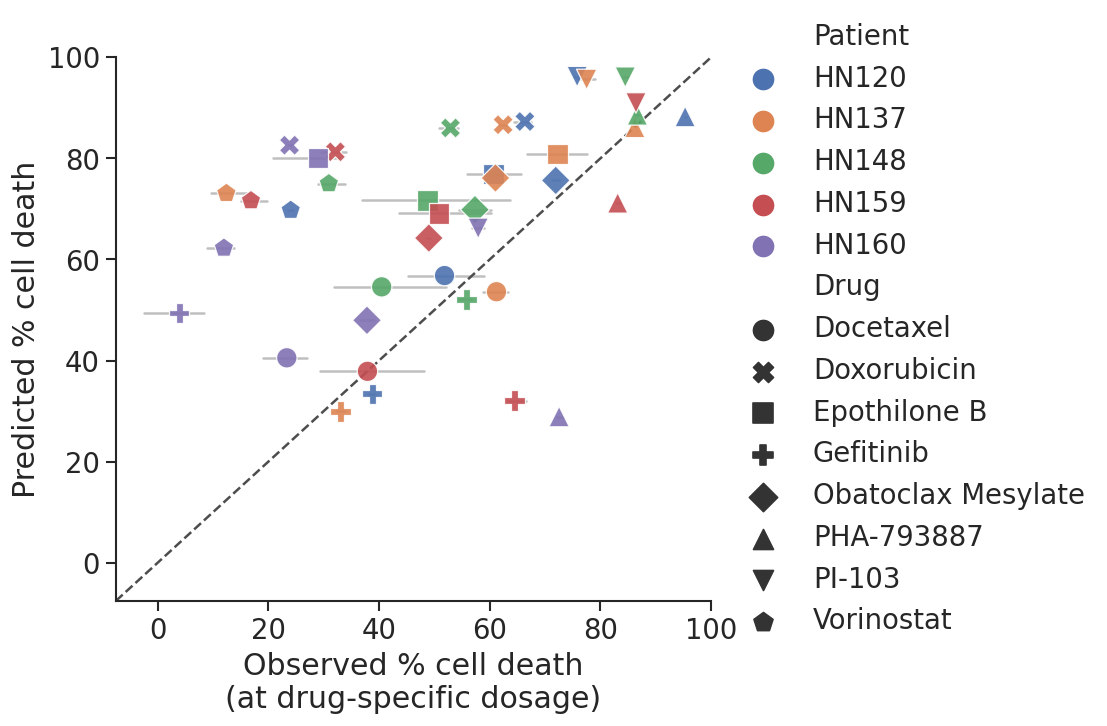

In [59]:
sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=scatter_single_df.groupby(['Drug', 'Patient']).mean().reset_index(), x='Observed % cell death', y='Predicted % cell death', hue='Patient', style='Drug', s=150, alpha=0.9, ax=ax)

for _, row in scatter_single_df.groupby(['Drug', 'Patient']).agg(['min', 'max', 'median']).iterrows():
    ax.plot([row[('Observed % cell death', 'min')], row[('Observed % cell death', 'max')]], 
            [row[('Predicted % cell death', 'median')], row[('Predicted % cell death', 'median')]], 
            color='grey', zorder=0, alpha=0.5)
    

vmin = scatter_single_df[['Observed % cell death', 'Predicted % cell death']].min().min()
vmax = scatter_single_df[['Observed % cell death', 'Predicted % cell death']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, 100))
ax.set_ylim((vmin-5, 100))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=2)

x = scatter_single_df.groupby(['Drug', 'Patient']).mean().reset_index()['Observed % cell death'].values
y = scatter_single_df.groupby(['Drug', 'Patient']).mean().reset_index()['Predicted % cell death'].values

scor, pval = stats.pearsonr(x, y)
print ('Single drug | Pearson r = {:.2f} ({:.2e})'.format(scor, pval))

r2 = metrics.r2_score(x, y)
print ('Single drug [R-sq {:.2f}%]'.format(r2*100))

if dosage_used == 'Median IC50':
    ax.set_xlabel('Observed % cell death\n(at drug-specific dosage)')
elif dosage_used == '3 fold':
    ax.set_xlabel('Observed % cell death\n(at 3-fold dilution)')
else:
    ax.set_xlabel('Observed % cell death\n({})'.format(dosage_used))

sns.despine()
# plt.tight_layout()

# fig.savefig('../figure/Fig4E_single_drug_{}_cell_{}.svg'.format(dosage_used, model))

#### For combi drug

In [60]:
obs_df = obs_combi_kill_df.loc[combi_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug combination', 'File name', 'Replicate', 'Patient', 'Observed % cell death']
print (obs_df.shape)

pred_df = pred_combi_kill_df.loc[[d[0] for d in obs_combi_kill_df.index], patient_list].stack().reset_index()
pred_df.columns = ['Drug combination', 'Patient', 'Predicted % cell death']
print (pred_df.shape)

scatter_combi_df = pd.concat([obs_df, pred_df[['Predicted % cell death']]], axis=1)
scatter_combi_df.loc[:, 'Replicate'] = scatter_combi_df['Replicate'].astype(str)
print (scatter_combi_df.shape)
scatter_combi_df.tail()

(70, 5)
(70, 3)
(70, 6)


,Drug combination,File name,Replicate,Patient,Observed % cell death,Predicted % cell death
65,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN120,85.90,99.12
66,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN137,94.32,99.16
67,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN148,91.27,98.89
68,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN159,92.54,97.21
69,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN160,65.67,93.25


Drug combination | 0.22 (2.80e-01)
Drug combination [R-sq -106.88%]


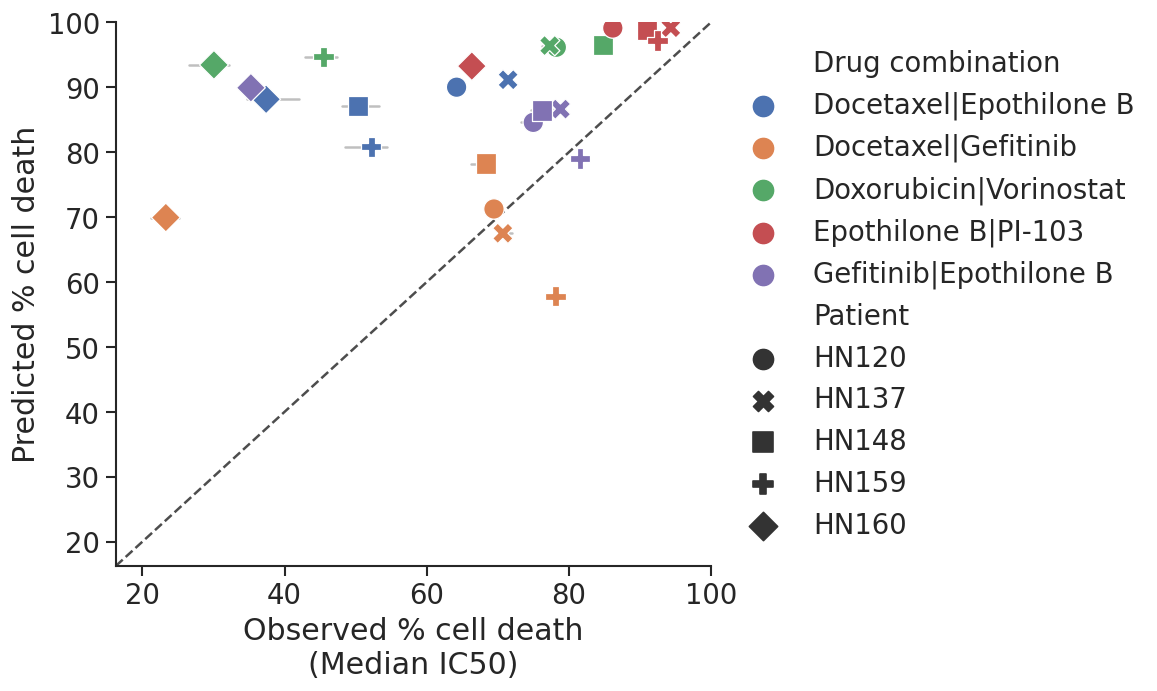

In [61]:
sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=scatter_combi_df.groupby(['Drug combination', 'Patient']).mean().reset_index(), x='Observed % cell death', y='Predicted % cell death', hue='Drug combination', style='Patient', s=150, alpha=1.0)

for _, row in scatter_combi_df.groupby(['Drug combination', 'Patient']).agg(['min', 'max', 'median']).iterrows():
    ax.plot([row[('Observed % cell death', 'min')], row[('Observed % cell death', 'max')]], 
            [row[('Predicted % cell death', 'median')], row[('Predicted % cell death', 'median')]], 
            color='grey', zorder=0, alpha=0.5)

vmin = scatter_combi_df[['Observed % cell death', 'Predicted % cell death']].min().min()
vmax = scatter_combi_df[['Observed % cell death', 'Predicted % cell death']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, 100))
ax.set_ylim((vmin-5, 100))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=2)

x = scatter_combi_df.groupby(['Drug combination', 'Patient']).mean().reset_index()['Observed % cell death'].values
y = scatter_combi_df.groupby(['Drug combination', 'Patient']).mean().reset_index()['Predicted % cell death'].values

scor, pval = stats.pearsonr(x, y)
print ('Drug combination | {:.2f} ({:.2e})'.format(scor, pval))

r2 = metrics.r2_score(x, y)
print ('Drug combination [R-sq {:.2f}%]'.format(r2*100))

if dosage_used == 'Median IC50':
    ax.set_xlabel('Observed % cell death\n(at drug-specific dosage)')
if dosage_used == '3 fold':
    ax.set_xlabel('Observed % cell death\n(at 3-fold dilution)')
else:
    ax.set_xlabel('Observed % cell death\n({})'.format(dosage_used))

sns.despine()

# fig.savefig('../figure/Fig4_combi_drug_{}_cell_{}.svg'.format(dosage_used, model))

### Compare improvement of drug combi over single drugs

In [62]:
pred_combi_imp_df = pred_combi_df[['patient', 'Combi Name', 'improve']].pivot(index='Combi Name', columns='patient', values='improve')
pred_combi_pimp_df = pred_combi_df[['patient', 'Combi Name', 'improve_p']].pivot(index='Combi Name', columns='patient', values='improve_p')

pred_combi_imp_df = pred_combi_imp_df.loc[combi_drug_list, patient_list]
pred_combi_pimp_df = pred_combi_pimp_df.loc[combi_drug_list, patient_list]

In [63]:
pred_combi_imp_df

patient,HN120,HN137,HN148,HN159,HN160
Combi Name,,,,,
Docetaxel|Epothilone B,13.15,10.23,15.45,11.69,8.09
Docetaxel|Gefitinib,14.43,13.88,23.66,19.93,20.51
Gefitinib|Epothilone B,7.73,5.71,14.75,9.90,9.86
Epothilone B|PI-103,2.93,3.54,2.81,6.24,13.20
Doxorubicin|Vorinostat,8.86,9.75,10.49,13.40,10.83


In [64]:
# TEMPORARY: using averge response

temp_df = obs_kill_df.loc[combi_drug_list].reset_index().drop(['File name', 'Replicate'], axis=1)
temp_df = temp_df.groupby('Drug').mean()
# temp_df = temp_df.loc[~temp_df.index.duplicated(keep='first')]
temp_df

,HN120,HN137,HN148,HN159,HN160,HN182
Drug,,,,,,
Docetaxel|Epothilone B,64.20,71.45,50.30,52.19,37.40,84.13
Docetaxel|Gefitinib,69.45,70.71,68.32,78.14,23.30,65.20
Doxorubicin|Vorinostat,78.23,77.29,84.78,45.46,30.06,65.83
Epothilone B|PI-103,86.18,94.34,90.95,92.48,66.34,83.01
Gefitinib|Epothilone B,74.99,78.81,76.18,81.57,35.26,88.09


In [65]:
imp_results = []
pimp_results = []
for c, data in temp_df.loc[combi_drug_list, patient_list].iterrows():
    a, b = c.split('|')
    
    c_kill = data.values
    best_kill = obs_kill_df.loc[[a, b]].max()[patient_list]
#     best_kill = obs_kill_df.loc[[a, b]].reset_index().groupby('Drug').mean()[patient_list].max()
    
#     print (c, c_kill, best_kill)
    
    imp = list((c_kill - best_kill).values)
    pimp = list(((c_kill - best_kill)/best_kill).values)
    
    imp_results += [[c] + imp]
    pimp_results += [[c] + pimp]
        
obs_combi_imp_df = pd.DataFrame(imp_results)
obs_combi_imp_df.columns = ['Drug combination'] + patient_list
obs_combi_imp_df = obs_combi_imp_df.set_index('Drug combination')

obs_combi_pimp_df = pd.DataFrame(pimp_results)
obs_combi_pimp_df.columns = ['Drug combination'] + patient_list
obs_combi_pimp_df = obs_combi_pimp_df.set_index('Drug combination')

obs_combi_imp_df = obs_combi_imp_df.loc[combi_drug_list, patient_list]
obs_combi_pimp_df = obs_combi_pimp_df.loc[combi_drug_list, patient_list]

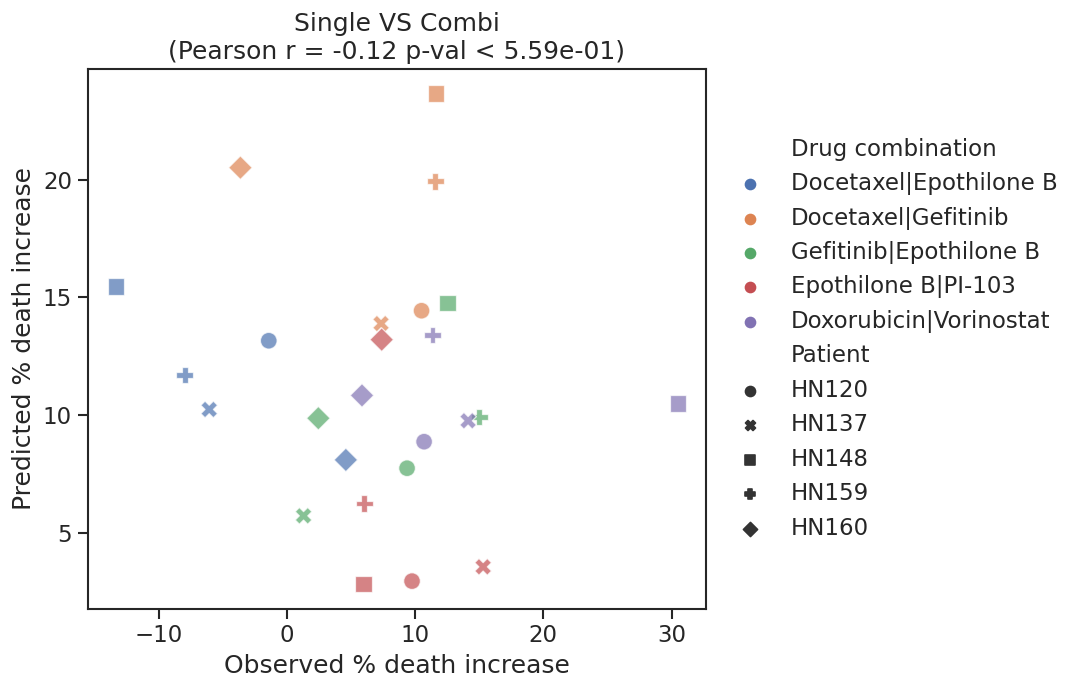

In [66]:
obs_df = obs_combi_imp_df.loc[combi_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug combination', 'Patient', 'Observed % death increase']

pred_df = pred_combi_imp_df.loc[combi_drug_list, patient_list].stack().reset_index()
pred_df.columns = ['Drug combination', 'Patient', 'Predicted % death increase']

sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
scatter_df = pd.merge(obs_df, pred_df, left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])

sns.scatterplot(data=scatter_df, x='Observed % death increase', y='Predicted % death increase', hue='Drug combination', style='Patient', s=100, alpha=0.7)
# sns.regplot(data=scatter_df, x='Observed % death increase', y='Predicted % death increase', x_ci='ci', ci=99, scatter=False, color='grey')
# plt.plot([0, 25], [0, 25], ls="--", c=".3")

vmin = scatter_df[['Observed % death increase', 'Predicted % death increase']].min().min()
vmax = scatter_df[['Observed % death increase', 'Predicted % death increase']].max().max()

# ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
# ax.set_xlim((vmin-5, vmax+5))
# ax.set_ylim((vmin-5, vmax+5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

scor, pval = stats.pearsonr(obs_df['Observed % death increase'].values, pred_df['Predicted % death increase'].values)
ax.set_title('Single VS Combi\n(Pearson r = {:.2f} p-val < {:.2e})'.format(scor, pval))

# r2 = metrics.r2_score(scatter_df['Observed % death increase'].values, scatter_df['Predicted % death increase'].values)
# ax.set_title('Single VS Combi [R-sq {:.2f}%]'.format(r2*100))

plt.tight_layout()
# fig.savefig('../figure/Fig4_improvement_{}_scatter_cell.svg'.format(dosage_used))

In [67]:
scatter_df.sort_values('Predicted % death increase', ascending=False)

,Drug combination,Patient,Observed % death increase,Predicted % death increase
7,Docetaxel|Gefitinib,HN148,11.62,23.66
9,Docetaxel|Gefitinib,HN160,-3.63,20.51
8,Docetaxel|Gefitinib,HN159,11.57,19.93
2,Docetaxel|Epothilone B,HN148,-13.34,15.45
12,Gefitinib|Epothilone B,HN148,12.54,14.75
5,Docetaxel|Gefitinib,HN120,10.50,14.43
6,Docetaxel|Gefitinib,HN137,7.34,13.88
23,Doxorubicin|Vorinostat,HN159,11.36,13.40
19,Epothilone B|PI-103,HN160,7.39,13.20
0,Docetaxel|Epothilone B,HN120,-1.41,13.15


In [68]:
def change_boxplot_edge_color(ax, col):
    for i, artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor(col)
        # artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

In [69]:
cutoff = 5

RanksumsResult(statistic=-0.3495310368212778, pvalue=0.726690674333039) Ttest_indResult(statistic=-0.38044374156503413, pvalue=0.7071070050128384)


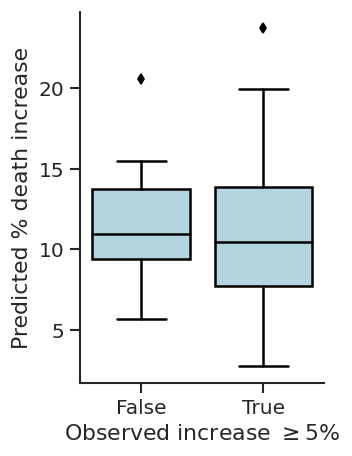

In [70]:
sns.set(font_scale=1.1, style='ticks')
fig, ax = plt.subplots(figsize=(3, 4))

merge_df = pd.merge(obs_df, pred_df, left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])
merge_df.loc[:, 'Observed increase'] = merge_df['Observed % death increase'] >= cutoff

sns.boxplot(data=merge_df, x='Observed increase', y='Predicted % death increase', fliersize=4, color='lightblue', ax=ax)
# sns.swarmplot(data=merge_df, x='Observed increase', y='Predicted % death increase', color='black', alpha=0.5, ax=ax)
change_boxplot_edge_color(ax, 'black')
ax.set_xlabel('Observed increase ' + r'$\geq {}\%$'.format(cutoff))

x = merge_df.loc[merge_df['Observed increase'], 'Predicted % death increase'].values
y = merge_df.loc[~merge_df['Observed increase'], 'Predicted % death increase'].values

sns.despine()
print (stats.ranksums(x, y), stats.ttest_ind(x, y))
plt.tight_layout()

# fig.savefig('../figure/Fig4_improvement_{}_{}_cell.svg'.format(dosage_used, cutoff))

In [71]:
print ("{:.2f} ({:.2e})".format(*stats.ranksums(x, y)))

-0.35 (7.27e-01)


In [72]:
obs = (merge_df['Observed % death increase'].values >= cutoff).astype(int)
pred = (merge_df['Predicted % death increase'].values >= cutoff).astype(int)
pred_val = merge_df['Predicted % death increase'].values

Counter(obs)

Counter({0: 8, 1: 17})

In [73]:
metrics.accuracy_score(obs, pred), metrics.f1_score(obs, pred, pos_label=1), metrics.f1_score(obs, pred, pos_label=0)

(0.56, 0.717948717948718, 0.0)

0.6769397765124171


(0.0, 1.1)

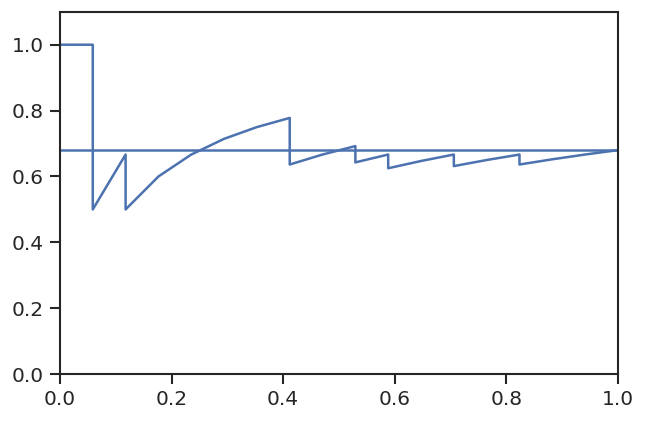

In [74]:
precision, recall, thresholds = metrics.precision_recall_curve(obs, pred_val)
plt.plot(recall, precision)

print (metrics.auc(recall, precision))

no_skill = len(obs[obs==1]) / len(obs)
plt.axhline(y=no_skill)

plt.xlim((0,1))
plt.ylim((0,1.1))

# fig.savefig('../figure/Fig4_pr_curve_{}_{}.svg'.format(dosage_used, cutoff))